# 6. Using additional features regarding player stastistics

---
**All features have been extracted, modelled, and stored to parquet files. If these are missing, please re-run the jupyter notebook [9_nhl_data_pipeline.ipynb](9_nhl_data_pipeline.ipynb)**

---

After first feature modelling and evaluation of the model using logistic regression, some other classifier and some other metrics will be considered.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math
import time

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix
from utils import balance_binary_target

from models import run_logistic_regression
from models import run_lightgbm_classifier
from models import run_kneighbors_classifier

from metrics import save_metrics
from metrics import plot_metrics
from metrics import init_metrics_file

sns.set()

---
### Use data prepared in [9_nhl_data_pipeline.ipynb](9_nhl_data_pipeline.ipynb)

In [2]:
# read data stored in a prepared parquet file
df_data_player = pd.read_parquet('data/_5_with_player_ids.parquet')
df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle,skater_id,goalie_id
index,,,,,,,,,,,,,,,,
0,2014020633_71,81.0,1.0,1,724,1,0,0,0,0,0,0,19.026298,3.012788,8474102,8473404.0
1,2018020644_270,83.0,-2.0,3,740,1,0,0,0,0,0,1,17.117243,6.709837,8480780,8476883.0
2,2011020858_283,75.0,-1.0,5,0,1,0,0,1,0,0,0,25.019992,2.290610,8469454,8473972.0
3,2015020726_249,84.0,7.0,3,271,1,0,0,1,0,0,0,17.464249,23.629378,8476878,8468685.0
4,2018020469_9,31.0,-8.0,1,47,1,0,0,1,0,0,0,69.462220,6.613460,8477495,8474593.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140437,2014020472_308,89.0,7.0,3,471,0,0,0,0,0,1,0,13.038405,32.471192,8471817,8471734.0
140438,2011020562_105,54.0,33.0,1,1198,0,0,0,1,0,0,0,56.612719,35.655328,8470611,8473503.0
140439,2011020235_28,68.0,5.0,1,290,0,0,0,0,0,0,1,32.388269,8.880659,8469500,8471469.0


___

========== Logistic Regression ==========
Accuracy: 0.5143
F1 Score: 0.0615
AUC-ROC Score: 0.5224
-----------------------------------------
Precision: 0.9985
Recall: 0.0318


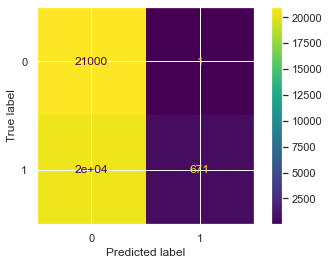

========== LightGBM Classifier ==========
Accuracy: 0.6958
F1 Score: 0.7096
AUC-ROC Score: 0.7550
-----------------------------------------
Precision: 0.6807
Recall: 0.7412


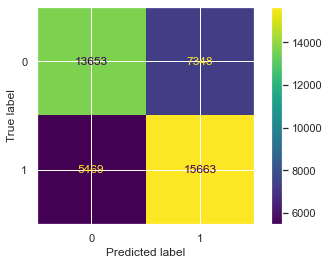

========= KNeighbors Classifier =========
Accuracy: 0.5294
F1 Score: 0.4914
AUC-ROC Score: 0.5456
-----------------------------------------
Precision: 0.5365
Recall: 0.4532


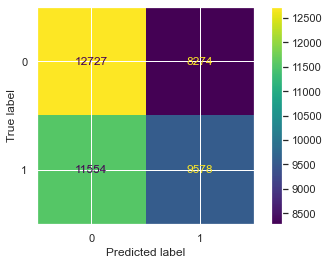

In [3]:
# starting training additionaly using player_id
_, lg = run_logistic_regression(df_data_player, c_matrix=True, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_player, c_matrix=True, r_curve=False);
_, knc = run_kneighbors_classifier(df_data_player, c_matrix=True, r_curve=False);
save_metrics('with_player_ids', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

---
Still balanced:

<AxesSubplot:>

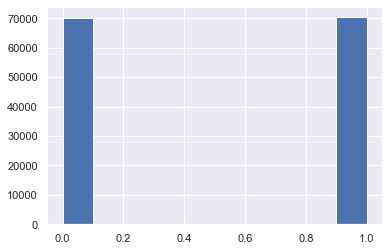

In [4]:
df_data_player.goal.hist()

## Adding player statistics

In [5]:
# read data stored in a prepared parquet file
df_data_player = pd.read_parquet('data/_6_with_player_stats.parquet')
df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,...,secondaryType_WristShot,distance,angle,skater_id,goalie_id,goals,shots,assists,timeOnIce,savePercentage
index,,,,,,,,,,,,,,,,,,,,,
0,2014020633_71,81.0,1.0,1,724,1,0,0,0,0,...,0,19.026298,3.012788,8474102,8473404.0,298,2286,431,1124550,90.159493
1,2018020644_270,83.0,-2.0,3,740,1,0,0,0,0,...,1,17.117243,6.709837,8480780,8476883.0,14,112,8,68932,91.413672
2,2011020858_283,75.0,-1.0,5,0,1,0,0,1,0,...,0,25.019992,2.290610,8469454,8473972.0,475,3555,480,1336504,90.564172
3,2015020726_249,84.0,7.0,3,271,1,0,0,1,0,...,0,17.464249,23.629378,8476878,8468685.0,78,891,97,547648,91.125365
4,2018020469_9,31.0,-8.0,1,47,1,0,0,1,0,...,0,69.462220,6.613460,8477495,8474593.0,90,1550,297,1023157,89.889683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140437,2014020472_308,89.0,7.0,3,471,0,0,0,0,0,...,0,13.038405,32.471192,8471817,8471734.0,68,656,74,478410,90.486440
140438,2011020562_105,54.0,33.0,1,1198,0,0,0,1,0,...,0,56.612719,35.655328,8470611,8473503.0,125,1248,118,564442,90.487457
140439,2011020235_28,68.0,5.0,1,290,0,0,0,0,0,...,1,32.388269,8.880659,8469500,8471469.0,297,2493,355,968225,90.269258


In [6]:
# starting training with player stats
_, lg = run_logistic_regression(df_data_player, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_player, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_data_player, c_matrix=False, r_curve=False);
save_metrics('with_player_stats', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

========== Logistic Regression ==========
Accuracy: 0.5516
F1 Score: 0.4954
AUC-ROC Score: 0.5870
-----------------------------------------
Precision: 0.5687
Recall: 0.4389
========== LightGBM Classifier ==========
Accuracy: 0.6974
F1 Score: 0.7119
AUC-ROC Score: 0.7595
-----------------------------------------
Precision: 0.6812
Recall: 0.7455
========= KNeighbors Classifier =========
Accuracy: 0.5609
F1 Score: 0.5696
AUC-ROC Score: 0.5859
-----------------------------------------
Precision: 0.5603
Recall: 0.5793


---
This is the best performing model for LightGBM so far. Accuracy very close to 0.70, F1-Score slightly over 0.71 

## Adding players salaries

In [7]:
# read data stored in a prepared parquet file
df_dataset = pd.read_parquet('data/_7_with_player_salary.parquet')
df_dataset

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,...,goalie_id,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality,salary
index,,,,,,,,,,,,,,,,,,,,,
0,2014020633_71,81.0,1.0,1,724,1,0,0,0,0,...,8473404.0,298,2286,431,1124550,90.159493,David,Perron,CAN,3750000.0
1,2018020644_270,83.0,-2.0,3,740,1,0,0,0,0,...,8476883.0,14,112,8,68932,91.413672,Lukas,Radil,CZE,3750000.0
3,2015020726_249,84.0,7.0,3,271,1,0,0,1,0,...,8468685.0,78,891,97,547648,91.125365,Zemgus,Girgensons,LVA,1150000.0
4,2018020469_9,31.0,-8.0,1,47,1,0,0,1,0,...,8474593.0,90,1550,297,1023157,89.889683,Seth,Jones,USA,5400000.0
6,2016020319_182,74.0,-7.0,3,86,1,0,0,0,0,...,8475717.0,217,1857,220,905195,88.548821,Alexandre,Burrows,CAN,3750000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140437,2014020472_308,89.0,7.0,3,471,0,0,0,0,0,...,8471734.0,68,656,74,478410,90.486440,Ryan,Reaves,CAN,1125000.0
140438,2011020562_105,54.0,33.0,1,1198,0,0,0,1,0,...,8473503.0,125,1248,118,564442,90.487457,Eric,Fehr,CAN,3750000.0
140439,2011020235_28,68.0,5.0,1,290,0,0,0,0,0,...,8471469.0,297,2493,355,968225,90.269258,Michael,Cammalleri,CAN,3750000.0


---
As we can see, there are new features for skater making the shot (goals, shots, assists, time on ice, salary) and for the goaling catching it (save percentage)

---

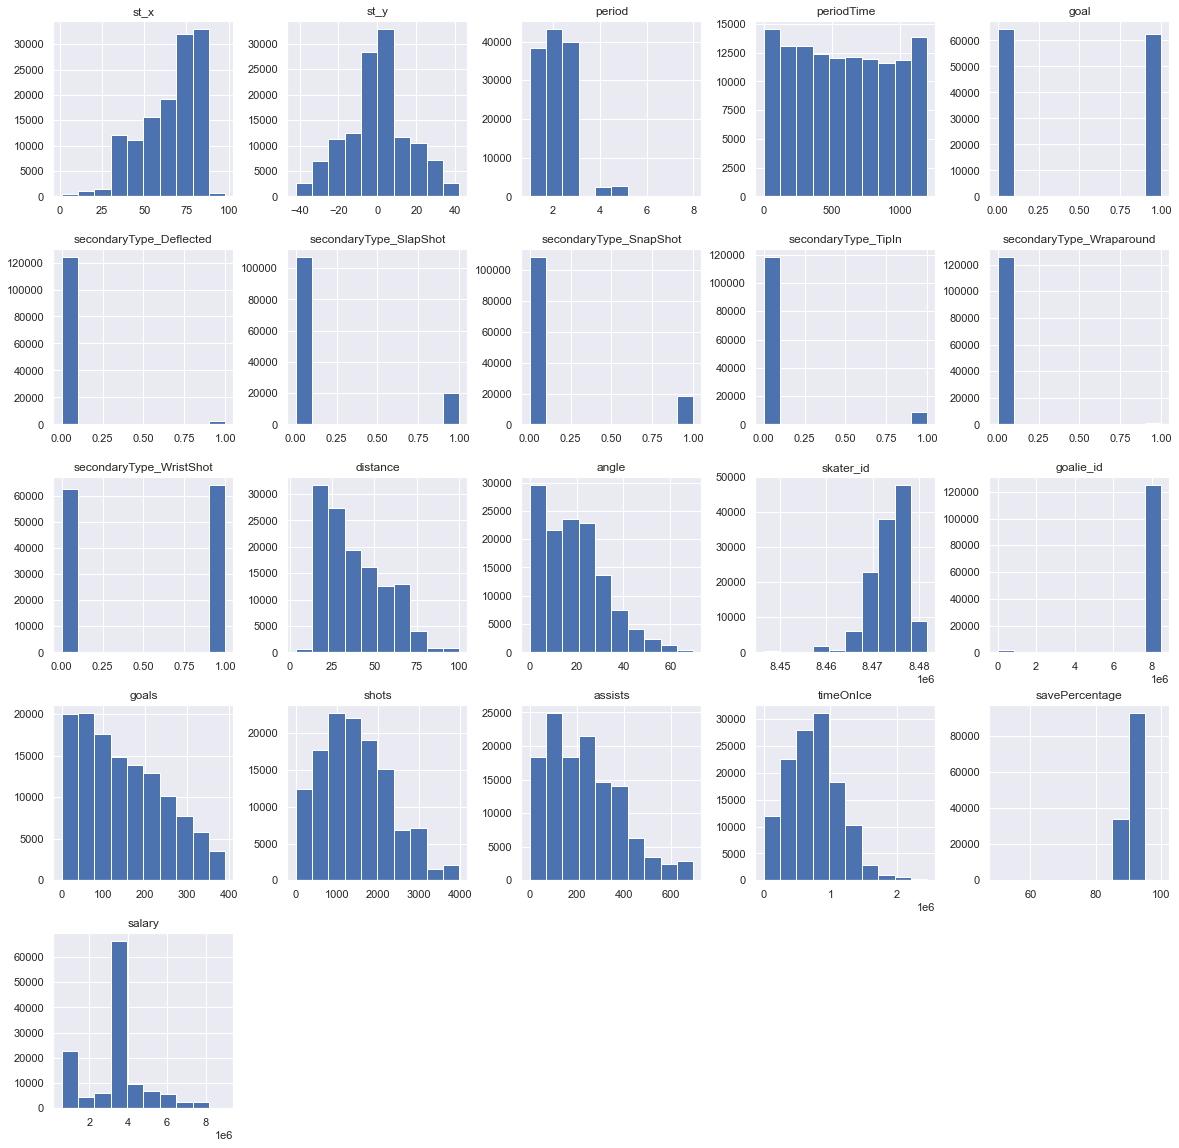

In [8]:
df_dataset.hist(figsize=(20, 20));


## Re-train models with the new dataset including player's data

In [9]:
# starting training with player salary
_, lg = run_logistic_regression(df_dataset, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_dataset, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_dataset, c_matrix=False, r_curve=False);

save_metrics('with_player_salary', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

========== Logistic Regression ==========
Accuracy: 0.5149
F1 Score: 0.1230
AUC-ROC Score: 0.5181
-----------------------------------------
Precision: 0.5872
Recall: 0.0687
========== LightGBM Classifier ==========
Accuracy: 0.6968
F1 Score: 0.7054
AUC-ROC Score: 0.7595
-----------------------------------------
Precision: 0.6797
Recall: 0.7330
========= KNeighbors Classifier =========
Accuracy: 0.5689
F1 Score: 0.5514
AUC-ROC Score: 0.5961
-----------------------------------------
Precision: 0.5688
Recall: 0.5350


---
There was not really and improvement in the model. The values are slightly worse.

---


### Look at the feature importance

========== LightGBM Classifier ==========
Accuracy: 0.6968
F1 Score: 0.7054
AUC-ROC Score: 0.7595
-----------------------------------------
Precision: 0.6797
Recall: 0.7330


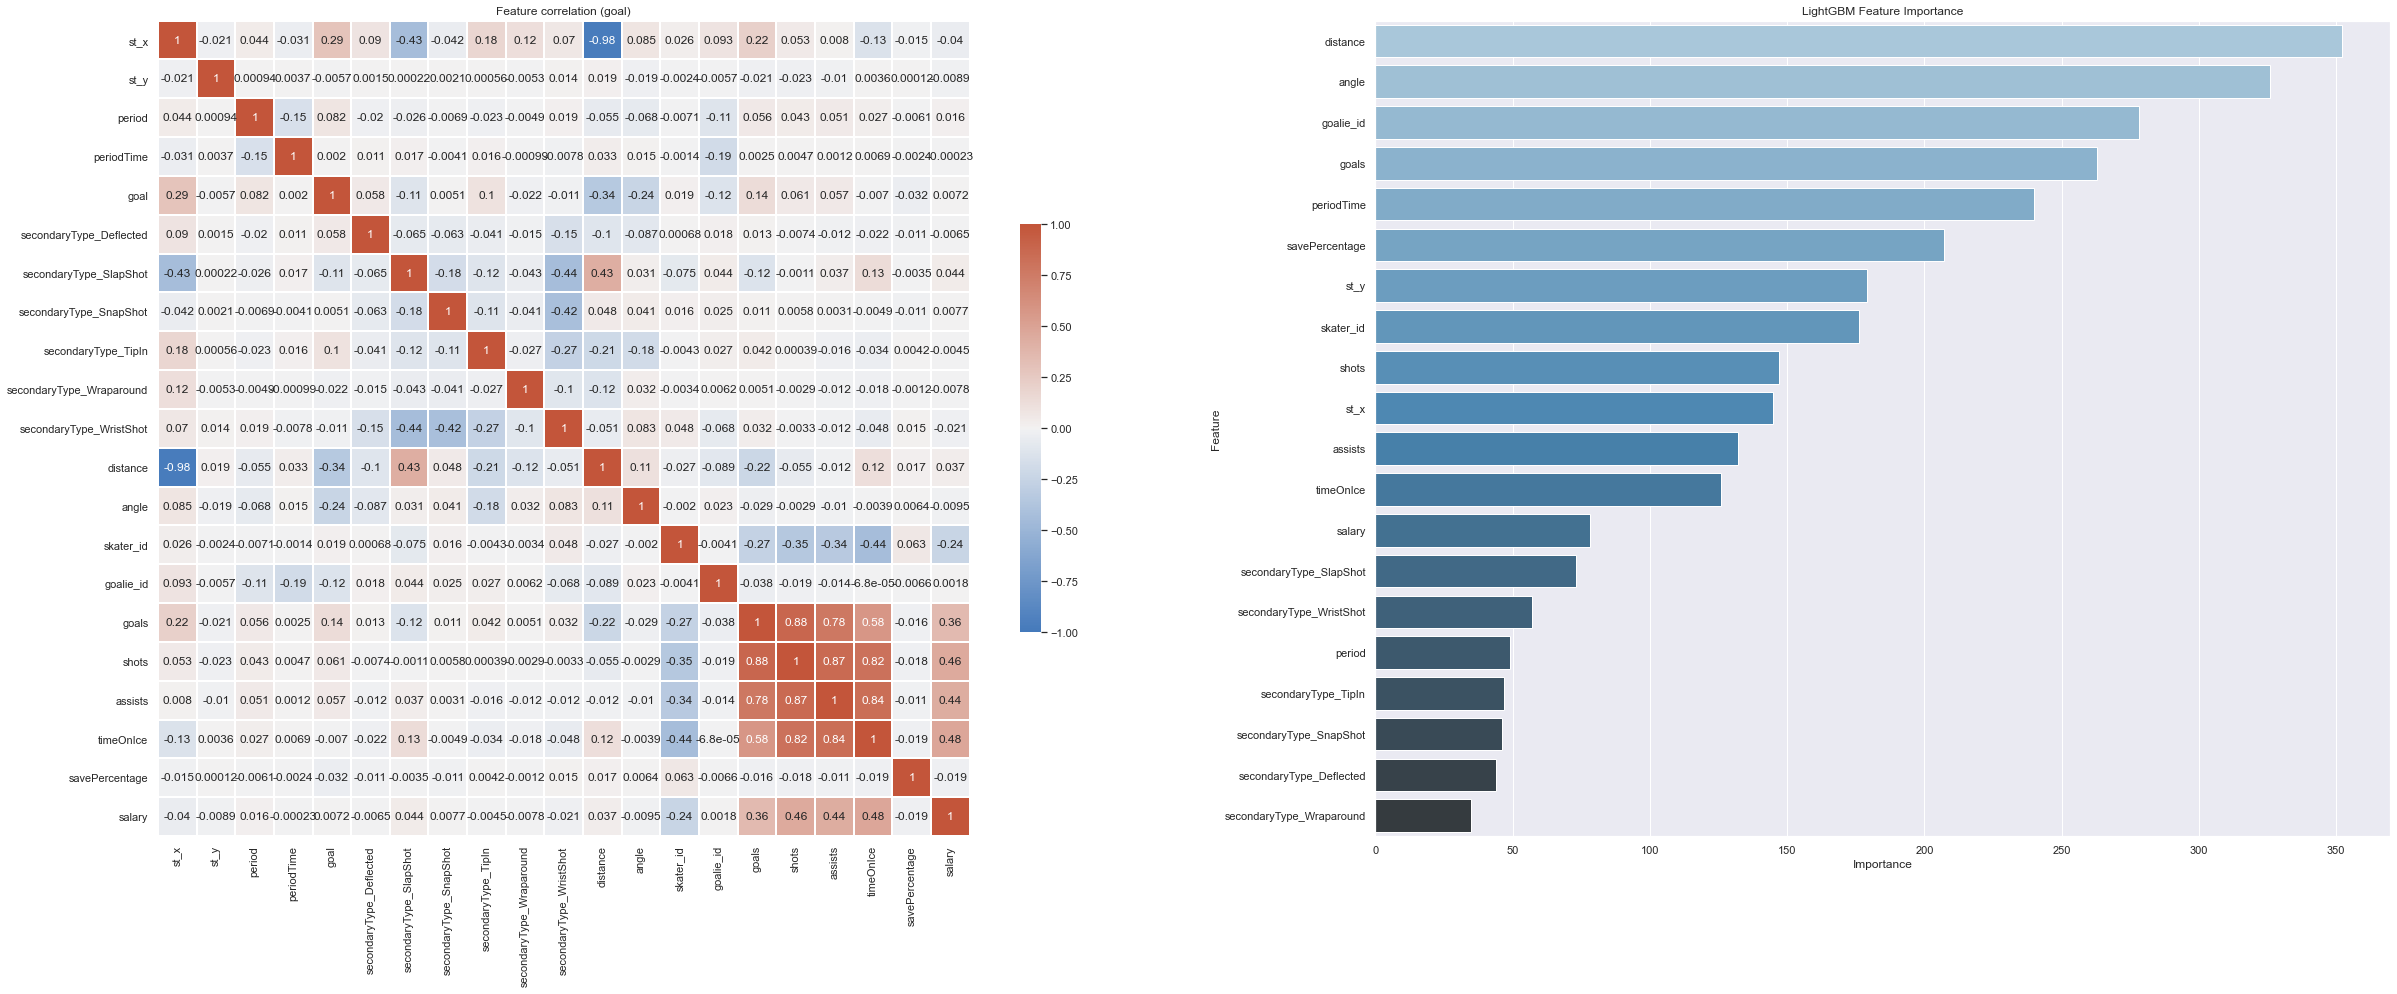

In [10]:
features = df_dataset.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model, _ = run_lightgbm_classifier(df_dataset, features=features, target=target, c_matrix=False, r_curve=False);


col='goal'
corr = df_dataset.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 15))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':lgbm_model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

This is actually very interesting ranking of important features. The top 4:
* distance: It's clear, distance can make the difference
* angle: Similar for angle
* goalie_id: Goalies capabilities is definitelly an important factor as well
* goals: Number of goals of the shooter is an important prior for the prediction

This all makes totally sense.

---

## Short vs. long distance shots

After all the feature engineering, let's see how is this model predisting on short vs. long distance shots. We split the dataset to two:

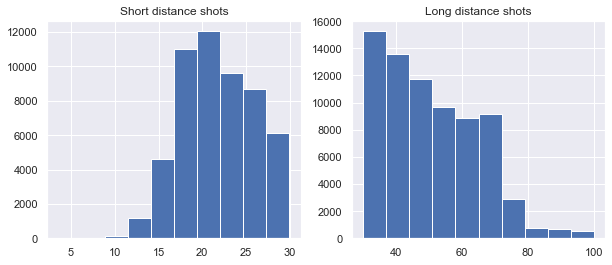

In [11]:
# read data stored in a prepared parquet files
df_short_dist = pd.read_parquet('data/_8_short_dist.parquet')
df_long_dist = pd.read_parquet('data/_9_long_dist.parquet')


plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(121)
df_short_dist.distance.hist();
plt.title('Short distance shots');
plt.subplot(122)
df_long_dist.distance.hist();
plt.title('Long distance shots');

---
Plotting locations of the short distance shots:

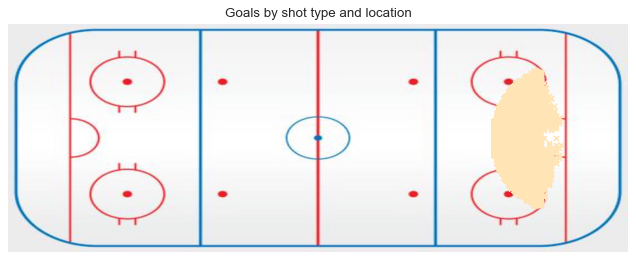

In [12]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
plt.scatter(df_short_dist.st_x, df_short_dist.st_y, s=20, c='moccasin', marker='x');
plt.title('Goals by shot type and location');

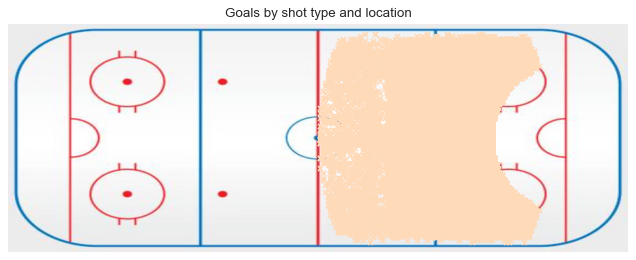

In [13]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
plt.scatter(df_long_dist.st_x, df_long_dist.st_y, s=20, c='peachpuff', marker='x');
plt.title('Goals by shot type and location');

---
Predicting goals for both this groups:

In [14]:
# training with short distance shots
_, lg = run_logistic_regression(df_short_dist, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_short_dist, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_short_dist, c_matrix=False, r_curve=False);

save_metrics('short_dist', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

========== Logistic Regression ==========
Accuracy: 0.6620
F1 Score: 0.7966
AUC-ROC Score: 0.5321
-----------------------------------------
Precision: 0.6620
Recall: 1.0000
========== LightGBM Classifier ==========
Accuracy: 0.6895
F1 Score: 0.7988
AUC-ROC Score: 0.6507
-----------------------------------------
Precision: 0.6994
Recall: 0.9312
========= KNeighbors Classifier =========
Accuracy: 0.6607
F1 Score: 0.7953
AUC-ROC Score: 0.5395
-----------------------------------------
Precision: 0.6622
Recall: 0.9954


In [15]:
_, lg = run_logistic_regression(df_long_dist, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_long_dist, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_long_dist, c_matrix=False, r_curve=False);

save_metrics('long_dist', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

========== Logistic Regression ==========
Accuracy: 0.6500
F1 Score: 0.0975
AUC-ROC Score: 0.5331
-----------------------------------------
Precision: 0.9976
Recall: 0.0512
========== LightGBM Classifier ==========
Accuracy: 0.7018
F1 Score: 0.5367
AUC-ROC Score: 0.7403
-----------------------------------------
Precision: 0.6287
Recall: 0.4681
========= KNeighbors Classifier =========
Accuracy: 0.6478
F1 Score: 0.1856
AUC-ROC Score: 0.5867
-----------------------------------------
Precision: 0.6311
Recall: 0.1088


---
The short distance goals are good predictable but...there is a clear imbalance again:
Logistic regression has high recall on short distance goals (everything predicted as goal due to unbalanced data) and high precision on long distance shots for similar reason:

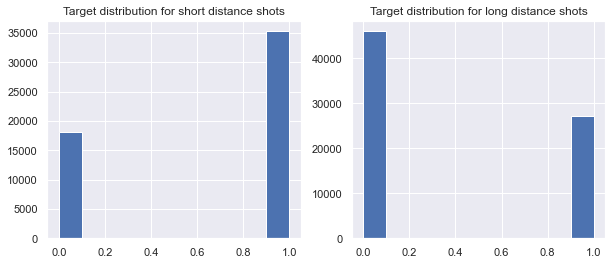

In [16]:
plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(121)
df_short_dist.goal.hist();
plt.title('Target distribution for short distance shots');

plt.subplot(122)
df_long_dist.goal.hist();
plt.title('Target distribution for long distance shots');



---
#### Balancing short distance shots:

In [17]:
df_short_dist = balance_binary_target(df_short_dist, 'goal')

In [18]:
_, lg = run_logistic_regression(df_short_dist, c_matrix=False, r_curve=False);
_, lgbm = run_lightgbm_classifier(df_short_dist, c_matrix=False, r_curve=False);
_, knc = run_kneighbors_classifier(df_short_dist, c_matrix=False, r_curve=False);

========== Logistic Regression ==========
Accuracy: 0.5198
F1 Score: 0.4900
AUC-ROC Score: 0.5309
-----------------------------------------
Precision: 0.5229
Recall: 0.4610
========== LightGBM Classifier ==========
Accuracy: 0.5945
F1 Score: 0.6153
AUC-ROC Score: 0.6394
-----------------------------------------
Precision: 0.5856
Recall: 0.6481
========= KNeighbors Classifier =========
Accuracy: 0.5227
F1 Score: 0.5079
AUC-ROC Score: 0.5367
-----------------------------------------
Precision: 0.5245
Recall: 0.4923


The dataset is balanced now, no high recall anymore. But...the model has lost (or was strongly reduced) one of the most important predictive features, which is **distance**. That's why is the performance not really good.